In [ ]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import ast
import random
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
advan_fairfax_path = 'data/fairfax_2019_10_weekly/fairfax_2019_10_weekly.csv'
acs_fairfax_path = 'data/ACSDT5Y2019.B01001_2024-11-12T023748/ACSDT5Y2019.B01001-Data.csv'

In [3]:
advan_data = pd.read_csv(advan_fairfax_path)
acs_data = pd.read_csv(acs_fairfax_path)
# Remove the first row as it contains explanations for each column
acs_data = acs_data.iloc[1:]


In [4]:
print(len(set(advan_data['poi_cbg'])))

665


In [5]:
# Define age groups
age_groups = {
    '00 - 09 years': ['B01001_003E', 'B01001_027E', 'B01001_004E', 'B01001_028E'], 
    '10 - 19 years': ['B01001_005E', 'B01001_029E', 'B01001_006E', 'B01001_030E', 'B01001_007E', 'B01001_031E'], 
    '20 - 29 years': ['B01001_008E', 'B01001_032E', 'B01001_009E', 'B01001_033E', 'B01001_010E', 'B01001_034E', 'B01001_011E', 'B01001_035E'], 
    '30 - 39 years': ['B01001_012E', 'B01001_036E', 'B01001_013E', 'B01001_037E'], 
    '40 - 49 years': ['B01001_014E', 'B01001_038E', 'B01001_015E', 'B01001_039E'], 
    '50 - 59 years': ['B01001_016E', 'B01001_040E', 'B01001_017E', 'B01001_041E'], 
    '60 + years': ['B01001_018E', 'B01001_042E', 'B01001_019E', 'B01001_043E', 'B01001_020E', 'B01001_044E', 'B01001_021E', 'B01001_045E', 
                   'B01001_022E', 'B01001_046E', 'B01001_023E', 'B01001_047E', 'B01001_024E', 'B01001_048E', 'B01001_025E', 'B01001_049E']
}

In [6]:
# Preprocess ACS data to get age group distribution per CBG
acs_data = acs_data.rename(columns={'GEO_ID': 'cbg'})
acs_data['cbg'] = acs_data['cbg'].str[-12:]


In [7]:
age_group_populations = {}
for group, columns in age_groups.items():
    acs_data[group] = acs_data[columns].apply(pd.to_numeric, errors='coerce').sum(axis=1)
    age_group_populations[group] = acs_data.groupby('cbg')[group].sum()

acs_age_distribution = pd.DataFrame(age_group_populations)
acs_age_distribution.reset_index(inplace=True)

In [8]:
# Normalize to get proportion of each age group per CBG
age_group_columns = list(age_groups.keys())
acs_age_distribution[age_group_columns] = acs_age_distribution[age_group_columns].div(acs_age_distribution[age_group_columns].sum(axis=1), axis=0).fillna(0)

In [9]:
print(acs_age_distribution)

              cbg  00 - 09 years  10 - 19 years  20 - 29 years  30 - 39 years  \
0    510594151001       0.086798       0.215901       0.061269       0.027717   
1    510594151002       0.140508       0.100149       0.065022       0.184604   
2    510594151003       0.192350       0.064481       0.061202       0.153005   
3    510594152001       0.063473       0.150898       0.092216       0.125749   
4    510594152002       0.020472       0.081890       0.185827       0.045669   
..            ...            ...            ...            ...            ...   
644  510594925001       0.095238       0.204010       0.062657       0.119799   
645  510594925002       0.045699       0.117204       0.034946       0.070968   
646  510599801001       0.000000       0.000000       0.000000       0.000000   
647  510599802001       0.000000       0.000000       0.000000       0.000000   
648  510599803001       0.000000       0.000000       0.000000       0.000000   

     40 - 49 years  50 - 59

In [10]:
# Preprocess Advan data to get visitation distribution by CBG for each POI
advan_data = advan_data.rename(columns={'placekey': 'poi_id', 'visitor_home_cbgs': 'visitor_cbg', 'visits_by_day': 'visits'})

# Parse the 'visitor_cbg' column to convert it from string to dictionary
advan_data['visitor_cbg'] = advan_data['visitor_cbg'].apply(lambda x: ast.literal_eval(str(x)) if pd.notna(x) else {})


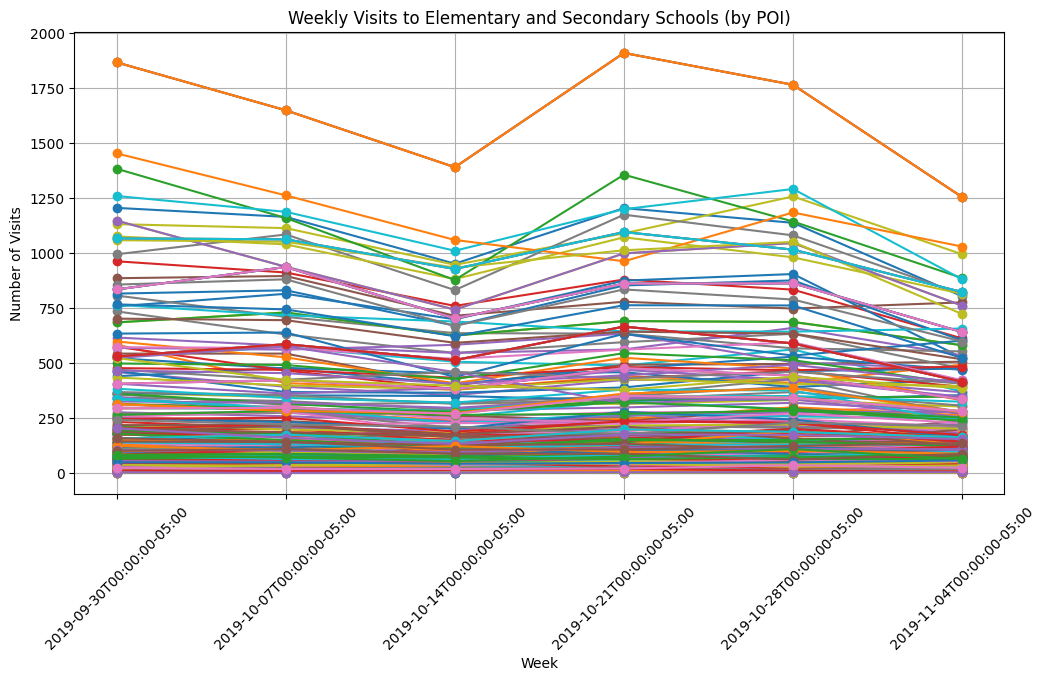

In [10]:
# Filter for POIs categorized as "Elementary and Secondary Schools"
school_visits = advan_data[advan_data['top_category'] == 'Elementary and Secondary Schools']

# Convert the date column to datetime format
# school_visits['date_range_start'] = pd.to_datetime(school_visits['date_range_start'])

# Group by POI and week
school_visits_grouped = school_visits.groupby(['poi_id', 'date_range_start'])['raw_visit_counts'].sum().reset_index()

# Plot visit trends for each POI
plt.figure(figsize=(12, 6))
for poi, poi_data in school_visits_grouped.groupby('poi_id'):
    plt.plot(poi_data['date_range_start'], poi_data['raw_visit_counts'], marker='o', linestyle='-', label=poi)

plt.xlabel('Week')
plt.ylabel('Number of Visits')
plt.title('Weekly Visits to Elementary and Secondary Schools (by POI)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [11]:
school_visits['total_visitors'] = school_visits['visitor_cbg'].apply(lambda x: sum(x.values()))
school_visits['visitor_cbg'].iloc[0]

C:\Users\james\AppData\Local\Temp\ipykernel_5932\3014877198.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  school_visits['total_visitors'] = school_visits['visitor_cbg'].apply(lambda x: sum(x.values()))


{'510594212001': 13,
 '510594224021': 5,
 '510594221012': 4,
 '510594224012': 4,
 '510594221011': 4,
 '510594224022': 4}

C:\Users\james\AppData\Local\Temp\ipykernel_5932\3351466050.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  school_visits['total_visitors'] = school_visits['visitor_cbg'].apply(lambda x: sum(x.values()))


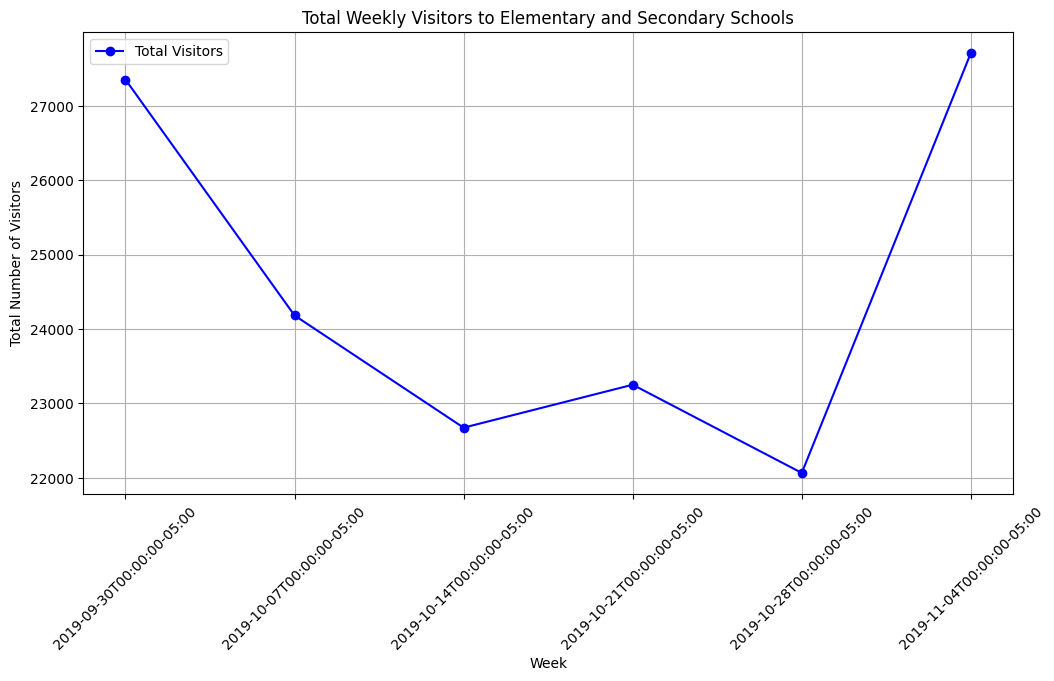

In [12]:
# Convert 'visitor_home_cbgs' from string to dictionary and sum visitor counts
school_visits['total_visitors'] = school_visits['visitor_cbg'].apply(lambda x: sum(x.values()))

# Aggregate total visitors across all schools per week
total_school_visitors = school_visits.groupby('date_range_start')['total_visitors'].sum().reset_index()

# Plot the overall trend of total visitors
plt.figure(figsize=(12, 6))
plt.plot(total_school_visitors['date_range_start'], total_school_visitors['total_visitors'], marker='o', linestyle='-', color='b', label='Total Visitors')

plt.xlabel('Week')
plt.ylabel('Total Number of Visitors')
plt.title('Total Weekly Visitors to Elementary and Secondary Schools')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Construct contact matrices for each POI and week
contact_matrices = {}
visitor_age_distributions ={}
include_cbgs_by_week = {}
include_visitors_by_week = {}
for _, row in advan_data.iterrows():
    poi_id = row['poi_id']
    week = row['date_range_start'] 
    visitor_cbgs = row['visitor_cbg']

    include_cbg_count = 0
    include_visitors = 0
    
    # Estimate the demographic composition of visitors
    visitor_demographics = pd.Series(0, index=age_groups.keys(), dtype=float)
    for cbg, count in visitor_cbgs.items():
        if cbg in acs_age_distribution['cbg'].values:
            cbg_age_distribution = acs_age_distribution.loc[acs_age_distribution['cbg'] == cbg, age_group_columns].iloc[0]
            if cbg_age_distribution.sum() > 0:  # Only sample if the population is greater than 0
                sampled_visitors = pd.Series([0] * len(age_group_columns), index=age_group_columns)
                for _ in range(count):                    
                    sampled_age_group = random.choices(age_group_columns, weights=cbg_age_distribution)[0]
                    sampled_visitors[sampled_age_group] += 1
                visitor_demographics += sampled_visitors
            include_cbg_count += 1
            include_visitors += count
        
    if week not in include_cbgs_by_week: 
        include_cbgs_by_week[week] = include_cbg_count
        include_visitors_by_week[week] = include_visitors
    else: 
        include_cbgs_by_week[week] += include_cbg_count
        include_visitors_by_week[week] += include_visitors
    
    # Normalize the visitor demographics
    total_visits = visitor_demographics.sum()
    # if total_visits > 0:
    #     visitor_demographics /= total_visits

    # Store the raw visitor age distribution for this POI and week
    visitor_age_distributions[(poi_id, week)] = visitor_demographics.to_dict()
    
    # Create contact matrix for the POI for the given week
    contact_matrix = pd.DataFrame(0, index=age_groups.keys(), columns=age_groups.keys())
    for age_group_1 in age_groups.keys():
        for age_group_2 in age_groups.keys():
            # Assume interaction rate is proportional to the product of the proportions
            contact_matrix.loc[age_group_1, age_group_2] = (
                visitor_demographics.get(age_group_1, 0) * visitor_demographics.get(age_group_2, 0)
            )
    
    # Store the contact matrix
    contact_matrices[(poi_id, week)] = contact_matrix

In [47]:
include_cbgs_by_week

{'2019-09-30T00:00:00-05:00': 476207,
 '2019-10-07T00:00:00-05:00': 442976,
 '2019-10-14T00:00:00-05:00': 443822,
 '2019-10-21T00:00:00-05:00': 425638,
 '2019-10-28T00:00:00-05:00': 427486,
 '2019-11-04T00:00:00-05:00': 461336}

In [48]:
include_visitors_by_week

{'2019-09-30T00:00:00-05:00': 3030634,
 '2019-10-07T00:00:00-05:00': 2721907,
 '2019-10-14T00:00:00-05:00': 2755338,
 '2019-10-21T00:00:00-05:00': 2503635,
 '2019-10-28T00:00:00-05:00': 2546598,
 '2019-11-04T00:00:00-05:00': 2938806}

In [44]:
missed_visitors_by_week

{'2019-09-30T00:00:00-05:00': 1812751,
 '2019-10-07T00:00:00-05:00': 1781481,
 '2019-10-14T00:00:00-05:00': 1698414,
 '2019-10-21T00:00:00-05:00': 1567375,
 '2019-10-28T00:00:00-05:00': 1586496,
 '2019-11-04T00:00:00-05:00': 1770907}

In [45]:
missed_pois_by_week

{'2019-09-30T00:00:00-05:00': 373008,
 '2019-10-07T00:00:00-05:00': 373937,
 '2019-10-14T00:00:00-05:00': 352589,
 '2019-10-21T00:00:00-05:00': 336431,
 '2019-10-28T00:00:00-05:00': 337702,
 '2019-11-04T00:00:00-05:00': 361656}

In [10]:

# Convert visitor age distributions to a DataFrame
visitor_age_df = pd.DataFrame.from_dict(visitor_age_distributions, orient='index')
visitor_age_df.index = pd.MultiIndex.from_tuples(visitor_age_df.index, names=['poi_id', 'week'])
visitor_age_df.reset_index(inplace=True)
visitor_age_df.to_csv('fairfax_visitor_age_distributions.csv', index=False)

NameError: name 'visitor_age_distributions' is not defined

In [9]:
# Filter for POIs in the "Elementary and Secondary Schools" category
school_pois = advan_data[advan_data['top_category'] == "Elementary and Secondary Schools"]['poi_id'].unique()

# Randomly pick 5 POIs
random.seed(42)
selected_pois = random.sample(list(school_pois), 5)

# Filter visitor age distribution for selected POIs
selected_pois_data = visitor_age_df[visitor_age_df['poi_id'].isin(selected_pois)]

NameError: name 'visitor_age_df' is not defined

C:\Users\james\AppData\Local\Temp\ipykernel_30832\181564163.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poi_data['total_visitors'] = poi_data.iloc[:, 2:].sum(axis=1)  # Sum across all age groups
C:\Users\james\AppData\Local\Temp\ipykernel_30832\181564163.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poi_data['total_visitors'] = poi_data.iloc[:, 2:].sum(axis=1)  # Sum across all age groups
C:\Users\james\AppData\Local\Temp\ipykernel_30832\181564163.py:5: SettingWithCopyWarning: 
A value is tryi

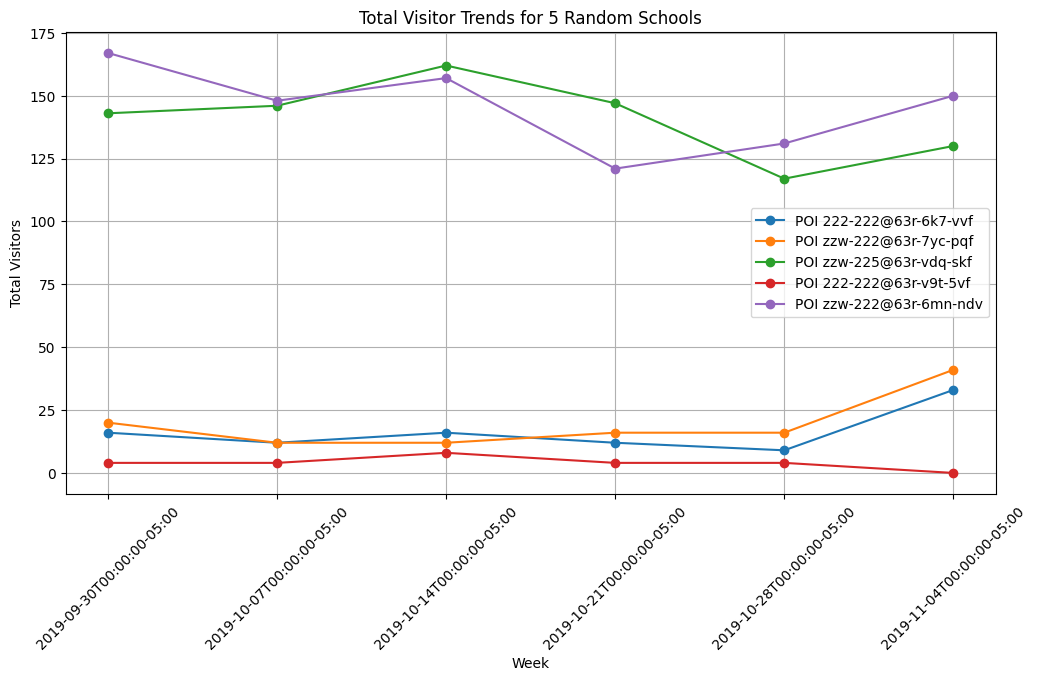

In [35]:
# Plot total visitor count trends for the selected POIs
plt.figure(figsize=(12, 6))
for poi in selected_pois:
    poi_data = selected_pois_data[selected_pois_data['poi_id'] == poi]
    poi_data['total_visitors'] = poi_data.iloc[:, 2:].sum(axis=1)  # Sum across all age groups
    plt.plot(poi_data['week'], poi_data['total_visitors'], marker='o', linestyle='-', label=f'POI {poi}')

plt.xlabel('Week')
plt.ylabel('Total Visitors')
plt.title('Total Visitor Trends for 5 Random Schools')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

<Figure size 1200x600 with 0 Axes>

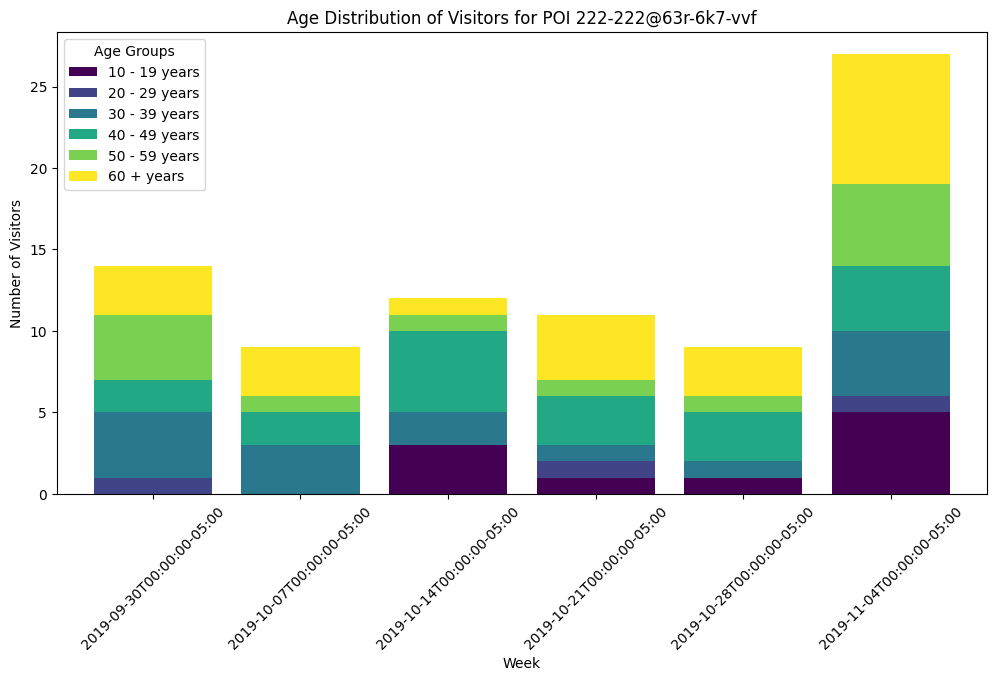

<Figure size 1200x600 with 0 Axes>

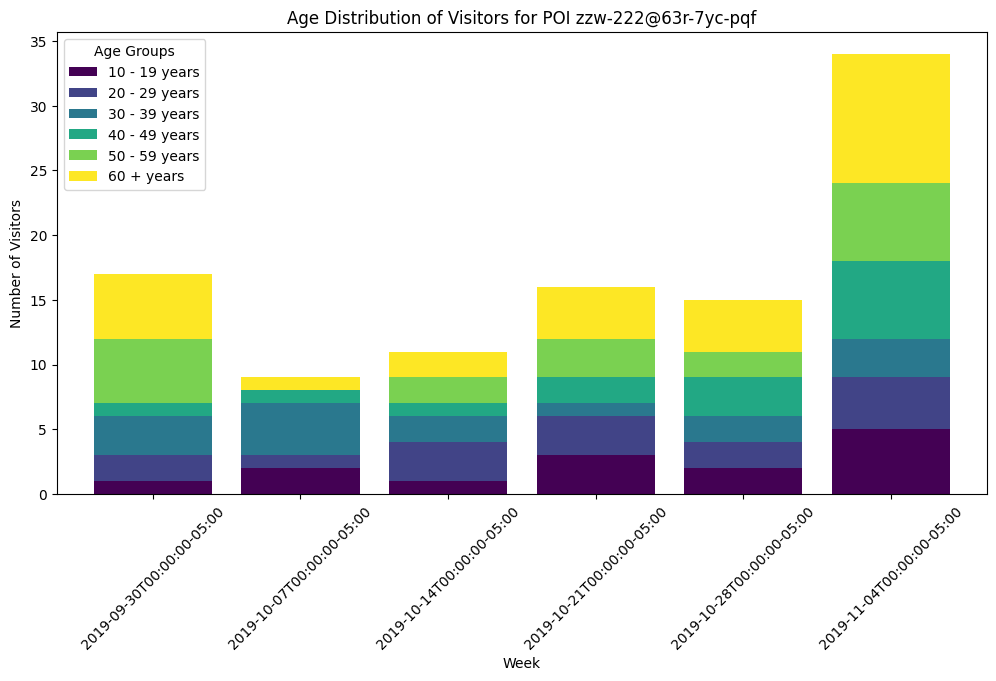

<Figure size 1200x600 with 0 Axes>

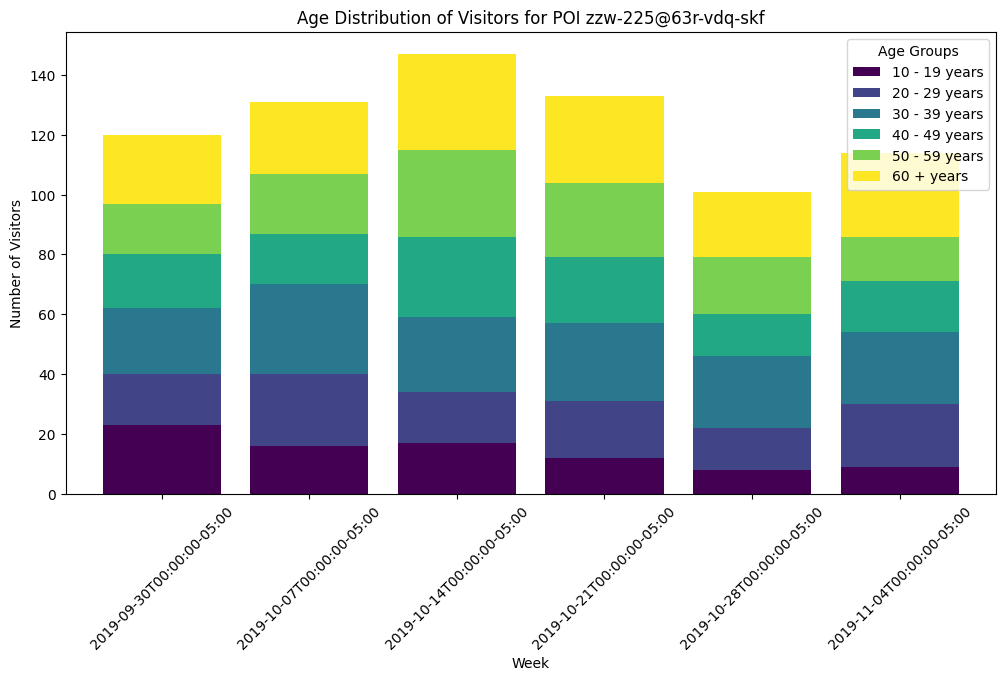

<Figure size 1200x600 with 0 Axes>

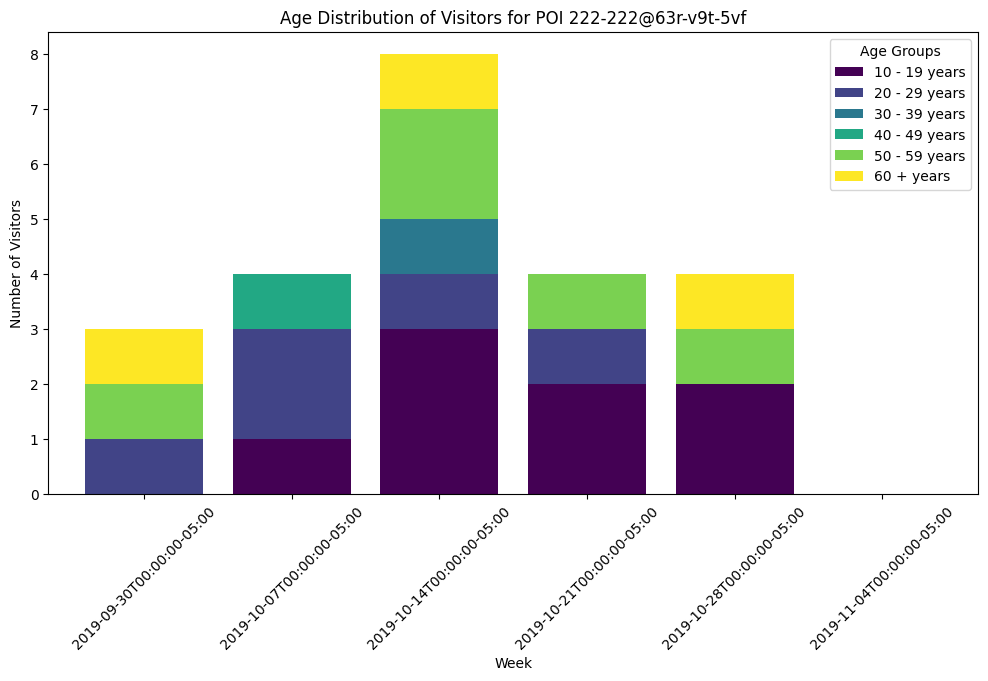

<Figure size 1200x600 with 0 Axes>

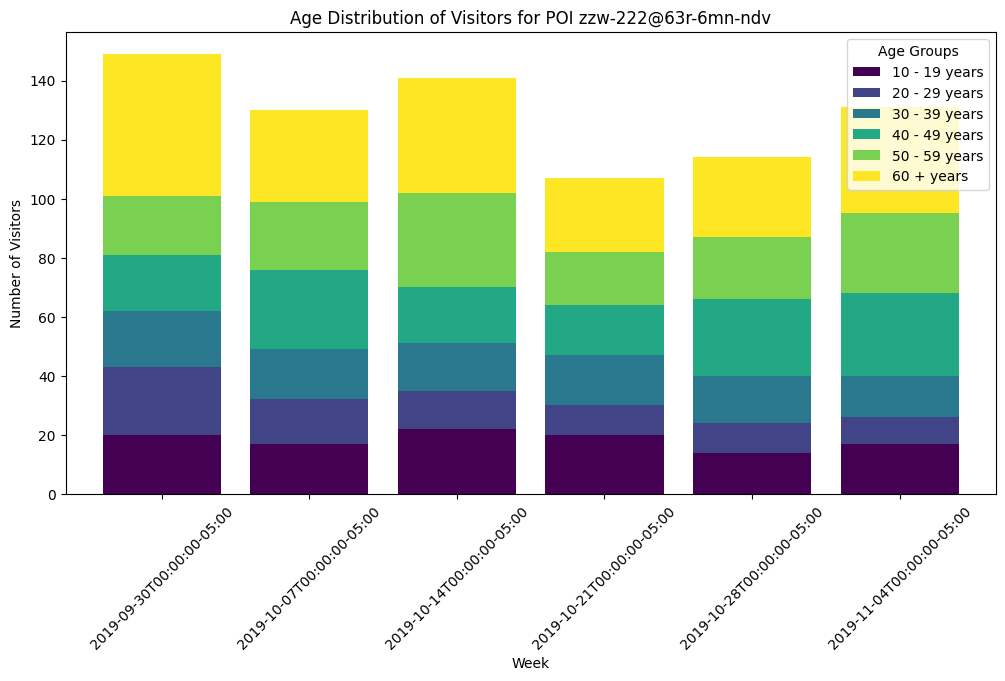

In [36]:
# Plot visitor age distributions over time for each selected POI
for poi in selected_pois:
    poi_data = selected_pois_data[selected_pois_data['poi_id'] == poi].set_index('week')
    poi_data = poi_data.iloc[:, 2:]  # Exclude POI ID and week columns

    plt.figure(figsize=(12, 6))
    poi_data.plot(kind='bar', stacked=True, colormap='viridis', figsize=(12, 6), width=0.8)
    plt.xlabel('Week')
    plt.ylabel('Number of Visitors')
    plt.title(f'Age Distribution of Visitors for POI {poi}')
    plt.xticks(rotation=45)
    plt.legend(title="Age Groups")
    plt.show()

<Figure size 1200x600 with 0 Axes>

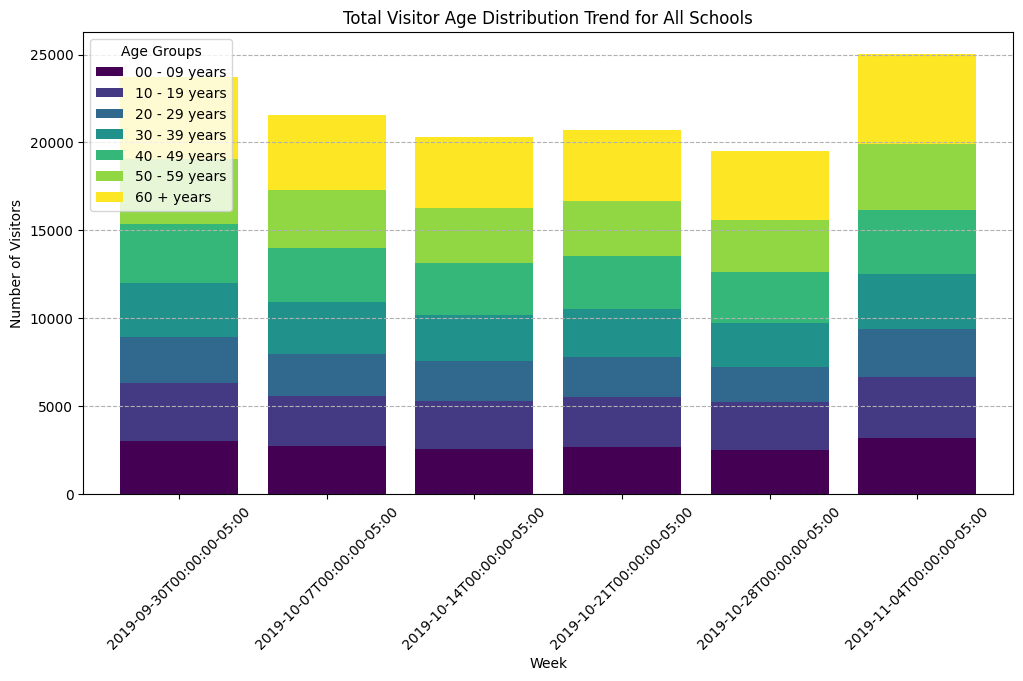

In [37]:
# Filter visitor age distribution for schools
school_age_data = visitor_age_df[visitor_age_df['poi_id'].isin(school_pois)]
# Aggregate visitor counts by week across all schools
school_age_trend = school_age_data.groupby('week').sum().drop(columns=['poi_id']).reset_index()

# Plot the total visitor age distribution trend
plt.figure(figsize=(12, 6))
school_age_trend.set_index('week').plot(kind='bar', stacked=True, colormap='viridis', figsize=(12, 6), width=0.8)

plt.xlabel('Week')
plt.ylabel('Number of Visitors')
plt.title('Total Visitor Age Distribution Trend for All Schools')
plt.xticks(rotation=45)
plt.legend(title="Age Groups")
plt.grid(axis='y', linestyle='--')
plt.show()

C:\Users\james\AppData\Local\Temp\ipykernel_30832\2178724550.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  school_age_data['num_age_groups'] = school_age_data.drop(columns=['poi_id', 'week']).gt(0).sum(axis=1)


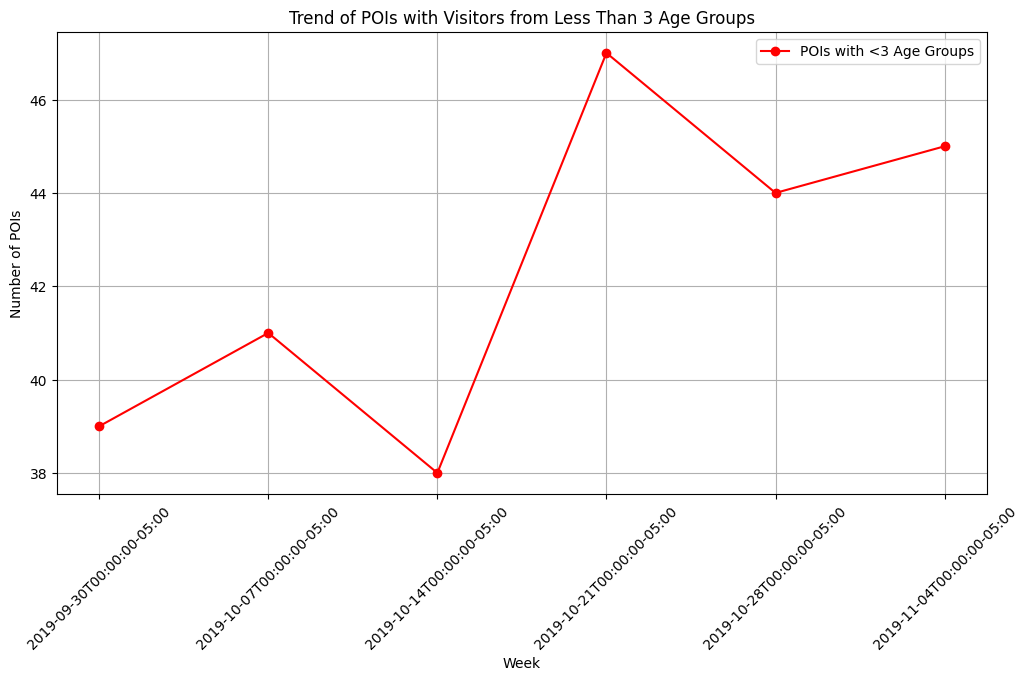

In [38]:
# Count the number of age groups with visitors for each POI and week
school_age_data['num_age_groups'] = school_age_data.drop(columns=['poi_id', 'week']).gt(0).sum(axis=1)

# Filter for POIs with fewer than 3 distinct age groups
low_diversity_pois = school_age_data[school_age_data['num_age_groups'] < 3]

# Count how many such POIs exist for each week
low_diversity_trend = low_diversity_pois.groupby('week')['poi_id'].nunique().reset_index()

# Plot the trend
plt.figure(figsize=(12, 6))
plt.plot(low_diversity_trend['week'], low_diversity_trend['poi_id'], marker='o', linestyle='-', color='r', label='POIs with <3 Age Groups')

plt.xlabel('Week')
plt.ylabel('Number of POIs')
plt.title('Trend of POIs with Visitors from Less Than 3 Age Groups')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

C:\Users\james\AppData\Local\Temp\ipykernel_30832\2401441013.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pois_above_100 = school_visits.groupby('date_range_start').apply(lambda x: (x['raw_visitor_counts'] > 100).sum()).reset_index()


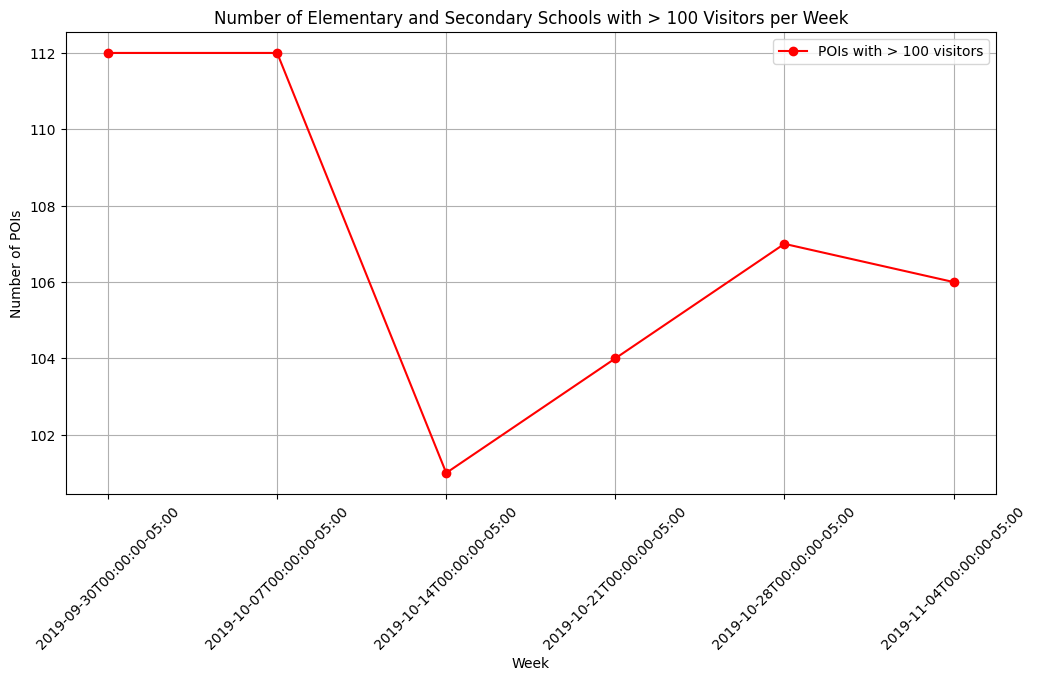

In [40]:
# Count POIs with total visitors > 100 each week
pois_above_100 = school_visits.groupby('date_range_start').apply(lambda x: (x['raw_visitor_counts'] > 100).sum()).reset_index()
pois_above_100.columns = ['date_range_start', 'num_pois_above_100']

# Plot the trend
plt.figure(figsize=(12, 6))
plt.plot(pois_above_100['date_range_start'], pois_above_100['num_pois_above_100'], marker='o', linestyle='-', color='r', label='POIs with > 100 visitors')

plt.xlabel('Week')
plt.ylabel('Number of POIs')
plt.title('Number of Elementary and Secondary Schools with > 100 Visitors per Week')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

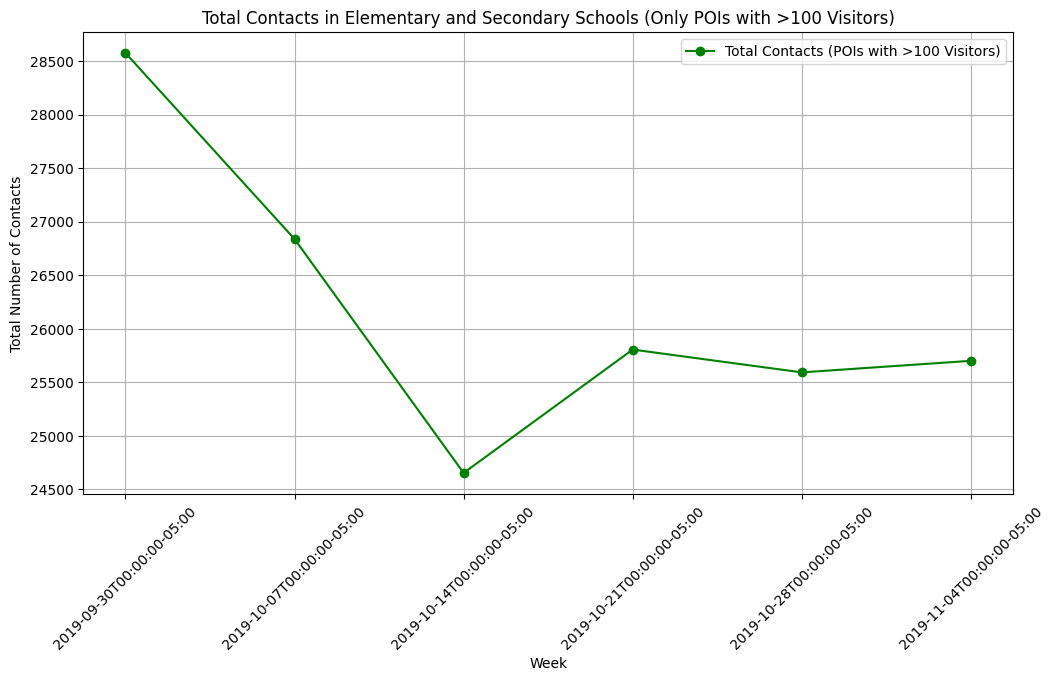

In [41]:
# Filter schools with >100 visitors each week
schools_above_100 = school_visits[school_visits['raw_visitor_counts'] > 100]

# Aggregate the total number of contacts (sum of contact matrices) per week
total_contacts_per_week = schools_above_100.groupby('date_range_start')['raw_visitor_counts'].sum().reset_index()

# Plot the trend
plt.figure(figsize=(12, 6))
plt.plot(total_contacts_per_week['date_range_start'], total_contacts_per_week['raw_visitor_counts'], marker='o', linestyle='-', color='g', label='Total Contacts (POIs with >100 Visitors)')

plt.xlabel('Week')
plt.ylabel('Total Number of Contacts')
plt.title('Total Contacts in Elementary and Secondary Schools (Only POIs with >100 Visitors)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

C:\Users\james\AppData\Local\Temp\ipykernel_30832\646873392.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  school_visits['visitor_category'] = pd.cut(school_visits['raw_visitor_counts'], bins=bins, labels=labels, right=True)
C:\Users\james\AppData\Local\Temp\ipykernel_30832\646873392.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  visitor_distribution = school_visits.groupby(['date_range_start', 'visitor_category']).size().unstack(fill_value=0)


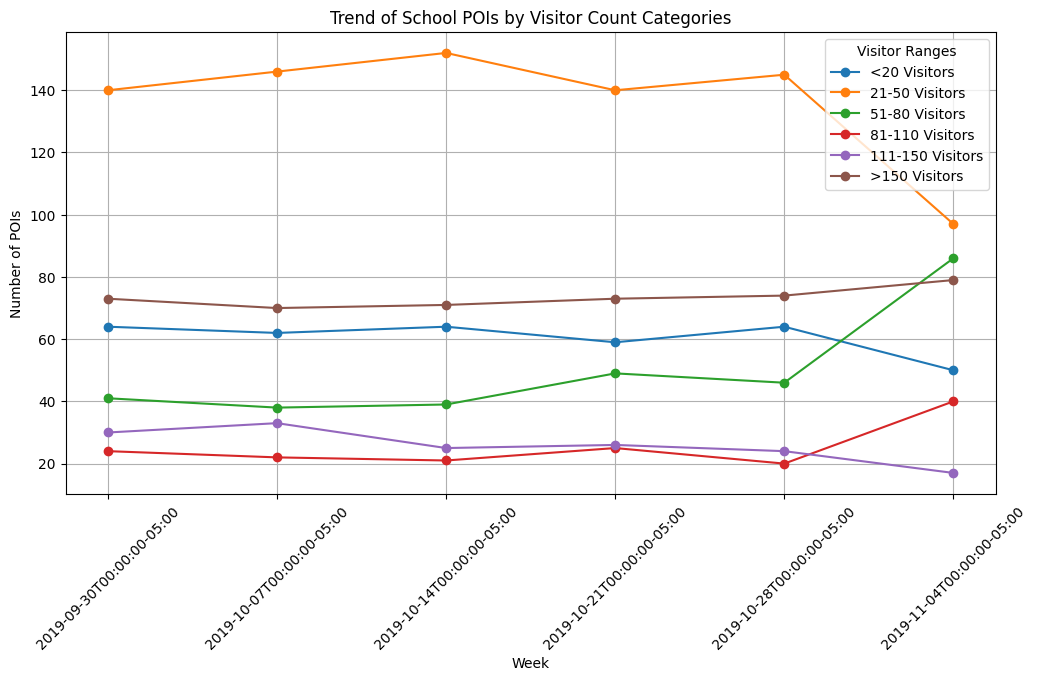

In [42]:
# Define visitor count bins
bins = [0, 20, 50, 80, 110, 150, float('inf')]
labels = ['<20', '21-50', '51-80', '81-110', '111-150', '>150']

# Assign each POI-week entry to a visitor count bin
school_visits['visitor_category'] = pd.cut(school_visits['raw_visitor_counts'], bins=bins, labels=labels, right=True)

# Count the number of POIs in each category per week
visitor_distribution = school_visits.groupby(['date_range_start', 'visitor_category']).size().unstack(fill_value=0)

# Plot the trends
plt.figure(figsize=(12, 6))
for category in labels:
    plt.plot(visitor_distribution.index, visitor_distribution[category], marker='o', linestyle='-', label=f'{category} Visitors')

plt.xlabel('Week')
plt.ylabel('Number of POIs')
plt.title('Trend of School POIs by Visitor Count Categories')
plt.xticks(rotation=45)
plt.legend(title="Visitor Ranges")
plt.grid(True)
plt.show()

In [20]:
import pickle

# Save contact_matrices to a file
with open('contact_matrices.pkl', 'wb') as f:
    pickle.dump(contact_matrices, f)

In [21]:
# Normalize each row so each row sums to 1
# contact_matrix_normalized = contact_matrix_example.div(contact_matrix_example.sum(axis=1), axis=0)
contact_matrix_normalized = contact_matrix_example # / contact_matrix_example.sum().sum()
print(contact_matrix_normalized)

               00 - 09 years  10 - 19 years  20 - 29 years  30 - 39 years  \
00 - 09 years              1              2              1              0   
10 - 19 years              2              4              2              0   
20 - 29 years              1              2              1              0   
30 - 39 years              0              0              0              0   
40 - 49 years              2              4              2              0   
50 - 59 years              3              6              3              0   
60 + years                 3              6              3              0   

               40 - 49 years  50 - 59 years  60 + years  
00 - 09 years              2              3           3  
10 - 19 years              4              6           6  
20 - 29 years              2              3           3  
30 - 39 years              0              0           0  
40 - 49 years              4              6           6  
50 - 59 years              6       

In [22]:
print(contact_matrix_normalized.sum().sum())

144


In [25]:
# Aggregate contact matrices of the same POI
monthly_contact_matrices = {}
for (poi_id, week), contact_matrix in contact_matrices.items():
    if poi_id not in monthly_contact_matrices:
        monthly_contact_matrices[poi_id] = contact_matrix
    else:
        monthly_contact_matrices[poi_id] += contact_matrix

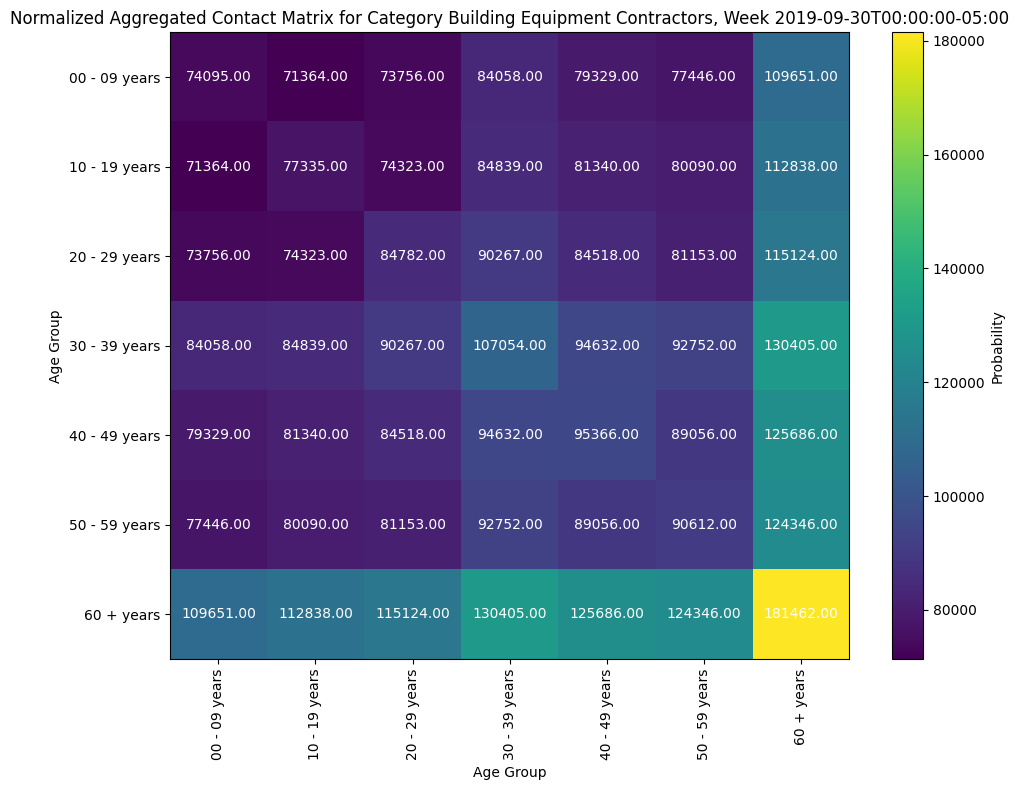

In [27]:
# Aggregate contact matrices by top_categories and week
category_week_contact_matrices = {}
for (poi_id, week), contact_matrix in contact_matrices.items():
    top_category = advan_data.loc[advan_data['poi_id'] == poi_id, 'top_category'].values[0]
    category_week_key = (top_category, week)
    if category_week_key not in category_week_contact_matrices:
        category_week_contact_matrices[category_week_key] = contact_matrix
    else:
        category_week_contact_matrices[category_week_key] += contact_matrix

# Example: Normalize and plot aggregated contact matrix for a specific category and week
example_category, example_week = list(category_week_contact_matrices.keys())[0]
aggregated_category_matrix = category_week_contact_matrices[(example_category, example_week)]

# Normalize the entire aggregated matrix so that the sum of all elements is 1
aggregated_category_matrix_normalized = aggregated_category_matrix # / aggregated_category_matrix.sum().sum()

# Plot the normalized aggregated contact matrix
plt.figure(figsize=(10, 8))
plt.imshow(aggregated_category_matrix_normalized, cmap='viridis', aspect='auto')
for i in range(aggregated_category_matrix_normalized.shape[0]):
    for j in range(aggregated_category_matrix_normalized.shape[1]):
        plt.text(j, i, f'{aggregated_category_matrix_normalized.iloc[i, j]:.2f}', ha='center', va='center', color='w')
plt.colorbar(label='Probability')
plt.xticks(ticks=np.arange(len(age_groups)), labels=age_groups.keys(), rotation=90)
plt.yticks(ticks=np.arange(len(age_groups)), labels=age_groups.keys())
plt.title(f"Normalized Aggregated Contact Matrix for Category {example_category}, Week {example_week}")
plt.xlabel("Age Group")
plt.ylabel("Age Group")
plt.tight_layout()
plt.show()

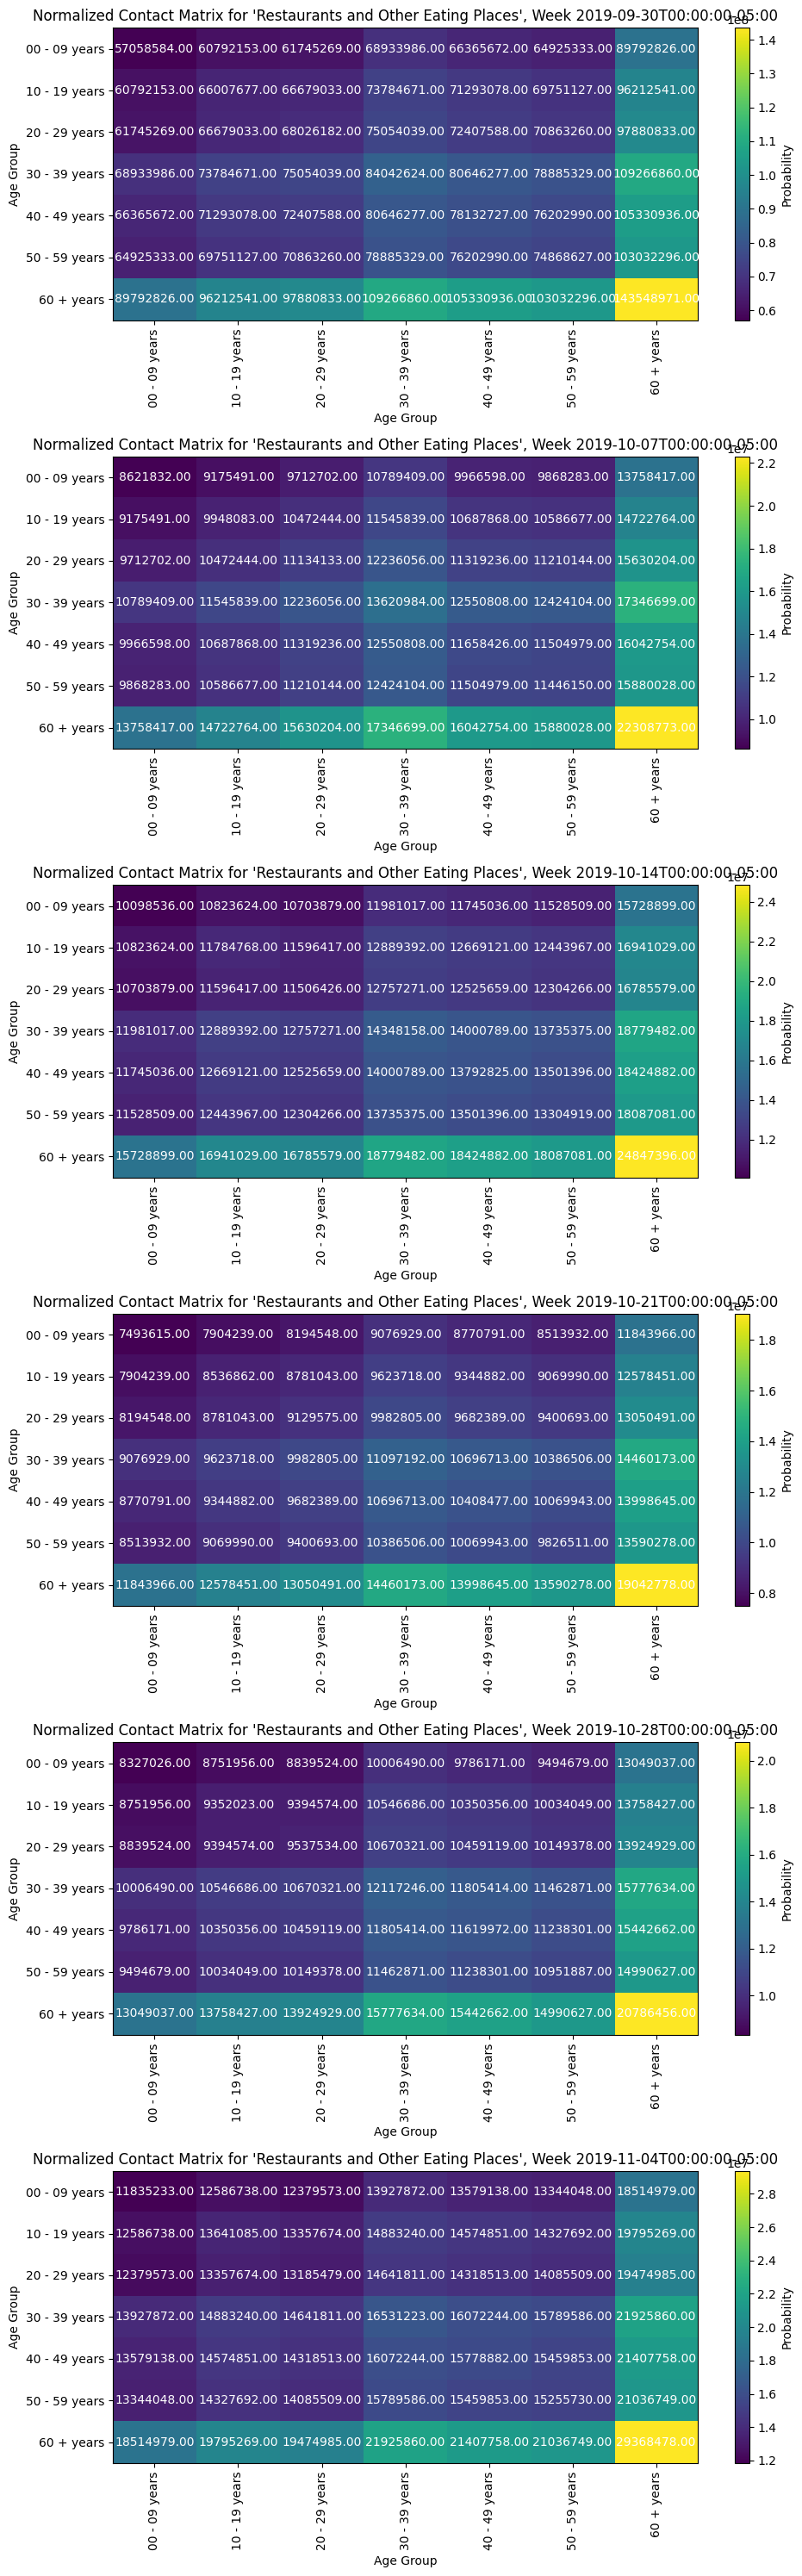

In [28]:
# Select a top category to visualize all weeks
example_category = "Restaurants and Other Eating Places"

# Filter out all contact matrices of the specified category across weeks
category_matrices = {
    week: matrix
    for (category, week), matrix in category_week_contact_matrices.items()
    if category == example_category
}

if category_matrices:
    # Create a plot for each week's contact matrix
    num_weeks = len(category_matrices)
    fig, axes = plt.subplots(nrows=num_weeks, figsize=(10, 5 * num_weeks))

    if num_weeks == 1:
        axes = [axes]  # Ensure axes is iterable for single subplot

    for ax, (week, matrix) in zip(axes, category_matrices.items()):
        # Normalize the contact matrix
        normalized_matrix = matrix # / matrix.sum().sum()

        # Plot the normalized contact matrix
        cax = ax.imshow(normalized_matrix, cmap='viridis', aspect='auto')
        for i in range(normalized_matrix.shape[0]):
            for j in range(normalized_matrix.shape[1]):
                ax.text(j, i, f'{normalized_matrix.iloc[i, j]:.2f}', ha='center', va='center', color='w')
        ax.set_xticks(np.arange(len(age_groups)))
        ax.set_xticklabels(age_groups.keys(), rotation=90)
        ax.set_yticks(np.arange(len(age_groups)))
        ax.set_yticklabels(age_groups.keys())
        ax.set_title(f"Normalized Contact Matrix for '{example_category}', Week {week}")
        ax.set_xlabel("Age Group")
        ax.set_ylabel("Age Group")
        fig.colorbar(cax, ax=ax, label='Probability')

    plt.tight_layout()
    plt.show()
else:
    print(f"No data available for the category '{example_category}'.")

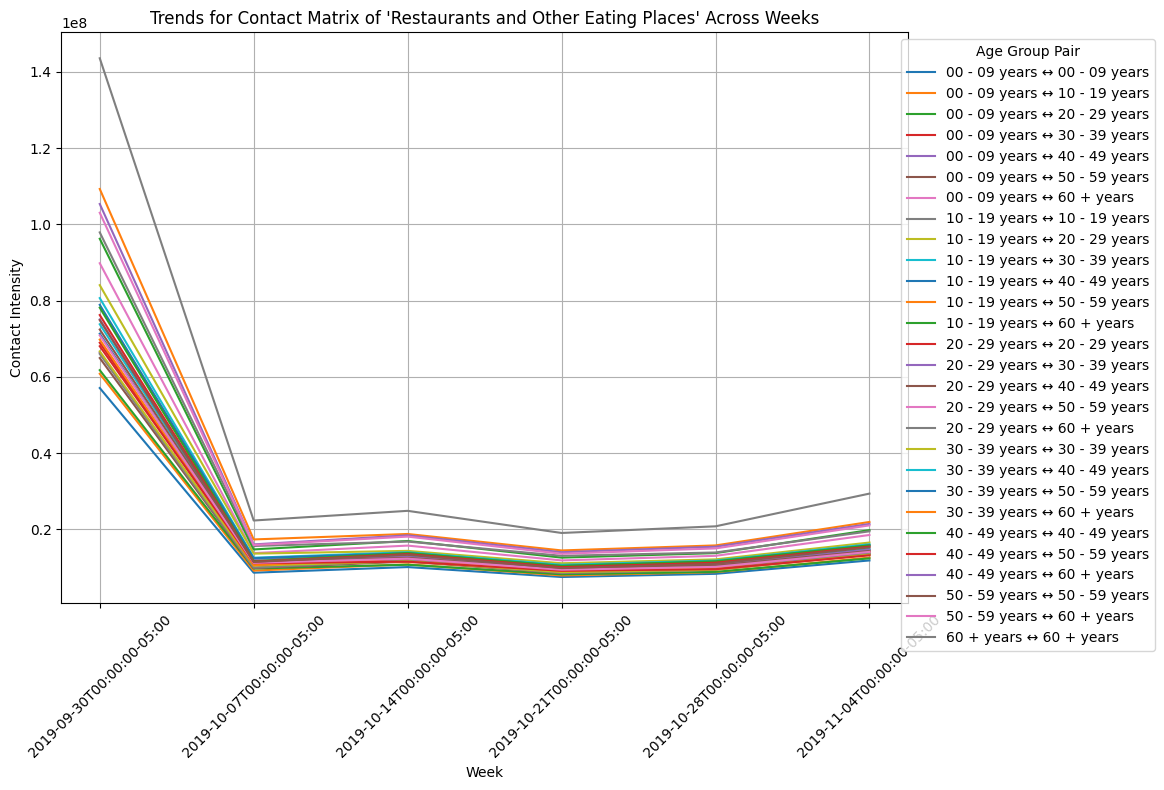

In [29]:
# Trend Analysis for Age Groups in Category Matrices
age_groups_name = list(age_groups.keys())
age_group_pairs = [(i, j) for i in range(len(age_groups_name)) for j in range(i, len(age_groups_name))]
trends = {pair: [] for pair in age_group_pairs}
weeks = sorted(category_matrices.keys())

# Collect trends for each pair of age groups
for week in weeks:
    matrix = category_matrices[week]
    for pair in age_group_pairs:
        trends[pair].append(matrix.iloc[pair[0], pair[1]])

# Plot the trends for selected age-group pairs
selected_pairs = [(0, 0), (0, 6), (3, 3), (6, 6)]  # Example pairs to analyze
plt.figure(figsize=(12, 8))
for pair in age_group_pairs:
    plt.plot(weeks, trends[pair], label=f"{age_groups_name[pair[0]]} ↔ {age_groups_name[pair[1]]}")

# Add plot details
plt.title(f"Trends for Contact Matrix of '{example_category}' Across Weeks")
plt.xlabel("Week")
plt.ylabel("Contact Intensity")
plt.xticks(rotation=45)
plt.legend(title="Age Group Pair", loc='upper right', bbox_to_anchor=(1.3, 1))
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

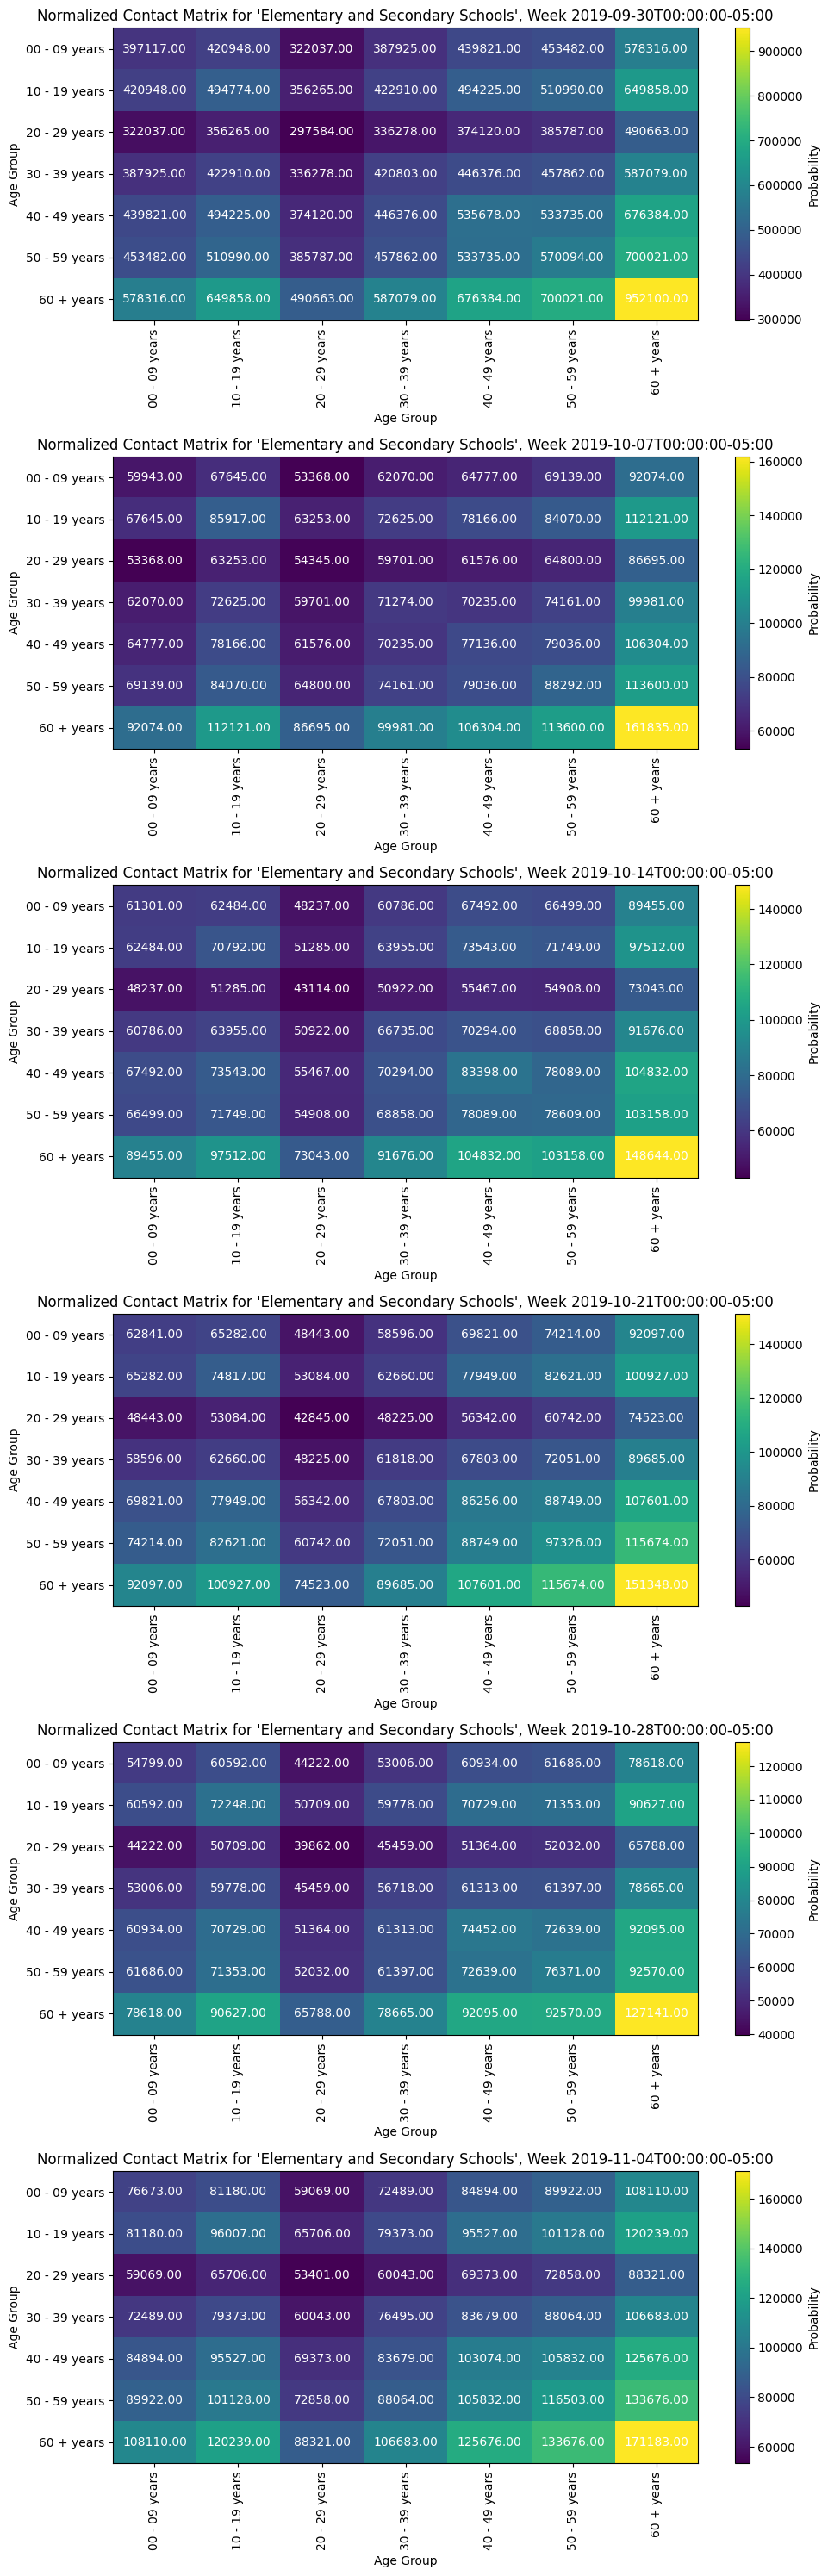

In [30]:
# Select a top category to visualize all weeks
example_category = "Elementary and Secondary Schools"

# Filter out all contact matrices of the specified category across weeks
category_matrices = {
    week: matrix
    for (category, week), matrix in category_week_contact_matrices.items()
    if category == example_category
}

if category_matrices:
    # Create a plot for each week's contact matrix
    num_weeks = len(category_matrices)
    fig, axes = plt.subplots(nrows=num_weeks, figsize=(10, 5 * num_weeks))

    if num_weeks == 1:
        axes = [axes]  # Ensure axes is iterable for single subplot

    for ax, (week, matrix) in zip(axes, category_matrices.items()):
        # Normalize the contact matrix
        normalized_matrix = matrix # / matrix.sum().sum()

        # Plot the normalized contact matrix
        cax = ax.imshow(normalized_matrix, cmap='viridis', aspect='auto')
        for i in range(normalized_matrix.shape[0]):
            for j in range(normalized_matrix.shape[1]):
                ax.text(j, i, f'{normalized_matrix.iloc[i, j]:.2f}', ha='center', va='center', color='w')
        ax.set_xticks(np.arange(len(age_groups)))
        ax.set_xticklabels(age_groups.keys(), rotation=90)
        ax.set_yticks(np.arange(len(age_groups)))
        ax.set_yticklabels(age_groups.keys())
        ax.set_title(f"Normalized Contact Matrix for '{example_category}', Week {week}")
        ax.set_xlabel("Age Group")
        ax.set_ylabel("Age Group")
        fig.colorbar(cax, ax=ax, label='Probability')

    plt.tight_layout()
    plt.show()
else:
    print(f"No data available for the category '{example_category}'.")

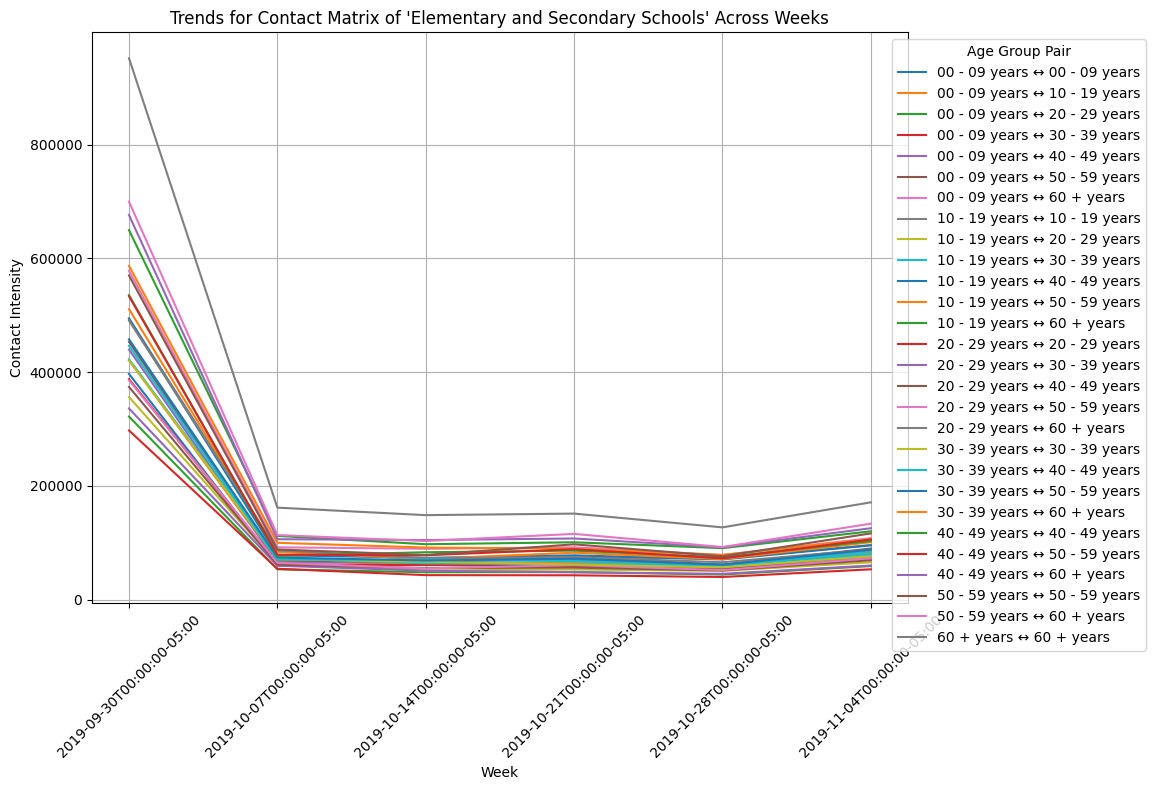

In [31]:
# Trend Analysis for Age Groups in Category Matrices
age_groups_name = list(age_groups.keys())
age_group_pairs = [(i, j) for i in range(len(age_groups_name)) for j in range(i, len(age_groups_name))]
trends = {pair: [] for pair in age_group_pairs}
weeks = sorted(category_matrices.keys())

# Collect trends for each pair of age groups
for week in weeks:
    matrix = category_matrices[week]
    for pair in age_group_pairs:
        trends[pair].append(matrix.iloc[pair[0], pair[1]])

# Plot the trends for selected age-group pairs
selected_pairs = [(0, 0), (0, 6), (3, 3), (6, 6)]  # Example pairs to analyze
plt.figure(figsize=(12, 8))
for pair in age_group_pairs:
    plt.plot(weeks, trends[pair], label=f"{age_groups_name[pair[0]]} ↔ {age_groups_name[pair[1]]}")

# Add plot details
plt.title(f"Trends for Contact Matrix of '{example_category}' Across Weeks")
plt.xlabel("Week")
plt.ylabel("Contact Intensity")
plt.xticks(rotation=45)
plt.legend(title="Age Group Pair", loc='upper right', bbox_to_anchor=(1.3, 1))
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

In [11]:
import pickle
with open('fairfax_contact_matrices.pkl', 'rb') as file:
    contact_matrices = pickle.load(file)


In [16]:
# Trend Analysis
age_groups_name = list(age_groups.keys())
age_group_pairs = [(i, j) for i in range(len(age_groups_name)) for j in range(i, len(age_groups_name))]
trends = {}
weeks = []

# Filter for POIs in the "Elementary and Secondary Schools" category
school_pois = advan_data[advan_data['top_category'] == "Elementary and Secondary Schools"]['poi_id'].unique()

# Randomly pick 5 POIs
random.seed(42)
selected_pois = random.sample(list(school_pois), 5)

for poi, week in contact_matrices.keys(): 
    if poi in selected_pois: 
        if poi not in trends: 
            trends[poi] = {pair: [] for pair in age_group_pairs}
        
        for pair in age_group_pairs:
            trends[poi][pair].append(contact_matrices[(poi, week)].iloc[pair[0], pair[1]])
    if week not in weeks: 
        weeks.append(week)

weeks


['2019-09-30T00:00:00-05:00',
 '2019-10-07T00:00:00-05:00',
 '2019-10-14T00:00:00-05:00',
 '2019-10-21T00:00:00-05:00',
 '2019-10-28T00:00:00-05:00',
 '2019-11-04T00:00:00-05:00']

In [ ]:
trends['zzw-225@63r-vdq-skf'].keys()

dict_keys([(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 3), (3, 4), (3, 5), (3, 6), (4, 4), (4, 5), (4, 6), (5, 5), (5, 6), (6, 6)])

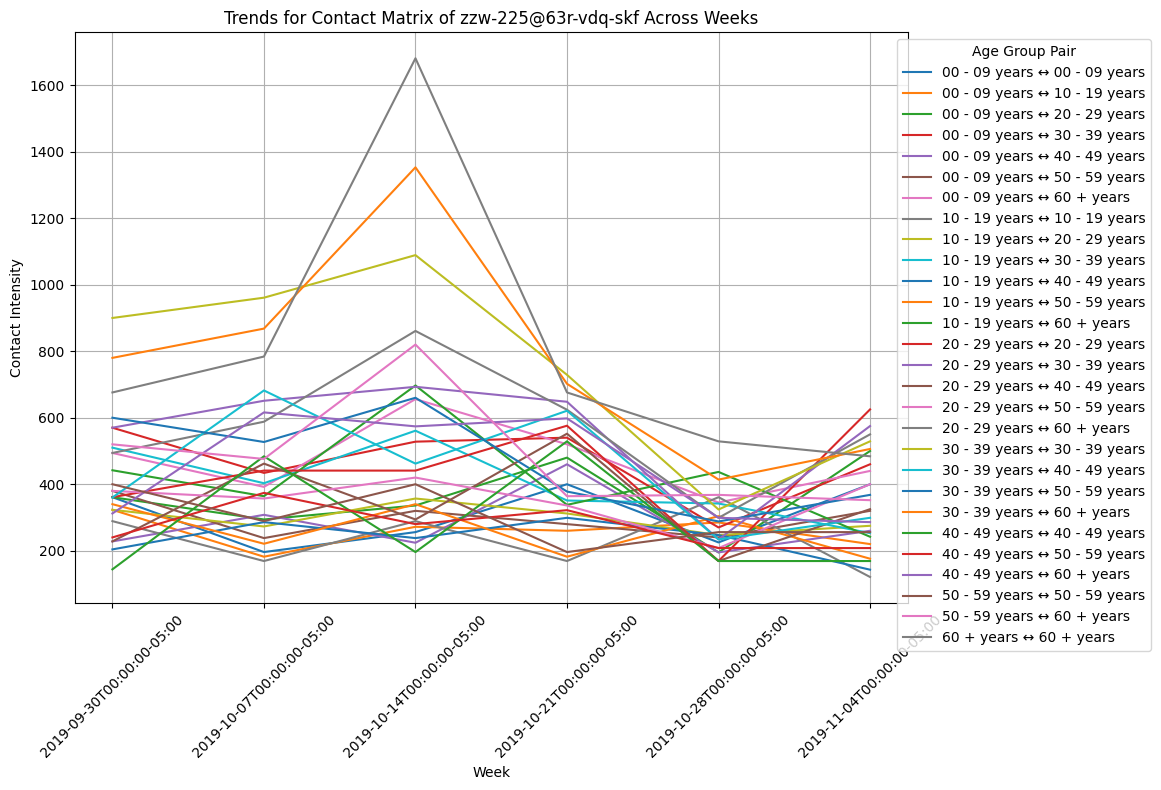

In [22]:
# Plot the trends for selected age-group pairs
selected_pairs = [(0, 0), (0, 6), (3, 3), (6, 6)]  # Example pairs to analyze
plt.figure(figsize=(12, 8))
for pair in age_group_pairs:
    plt.plot(weeks, trends['zzw-225@63r-vdq-skf'][pair], label=f"{age_groups_name[pair[0]]} ↔ {age_groups_name[pair[1]]}")

# Add plot details
plt.title(f"Trends for Contact Matrix of zzw-225@63r-vdq-skf Across Weeks")
plt.xlabel("Week")
plt.ylabel("Contact Intensity")
plt.xticks(rotation=45)
plt.legend(title="Age Group Pair", loc='upper right', bbox_to_anchor=(1.3, 1))
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()